# Customer Segmentation: Small Business Owners in the United States

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Prepare Data

### Import 

In [2]:
# import data
df = pd.read_csv("Data/scfp2019excel.zip")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


### Explore


In [3]:
# calculate proportion of business owners
prop_biz_owners = df["HBUS"].value_counts(normalize=True)[1]
print("proportion of business owners in df:", round(prop_biz_owners, 2))

proportion of business owners in df: 0.27


27% of respondents in the survey are business owners

In [4]:
# create replacement dictionary
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

# create dataframe of income categories for business/non-business owners
df_inccat = (
    df['INCCAT']
    .replace(inccat_dict)
    .groupby(df['HBUS'])
    .value_counts(normalize=True)
    .rename('frequency')
    .to_frame()
    .reset_index()
)

# display dataframe
df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


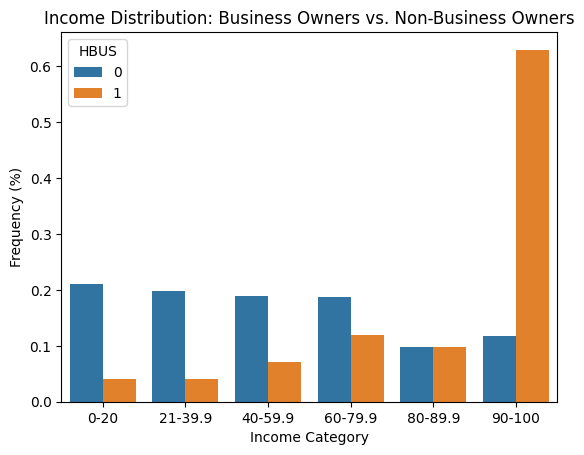

In [5]:
# Create bar chart of `df_inccat`
sns.barplot(
    x='INCCAT',
    y = 'frequency',
    hue = 'HBUS',
    data = df_inccat,
    order = inccat_dict.values()
)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");


Majority of the respondents in the 90th to 100th percentile income groups are families with businesses. This accounts for 60% of the responses.

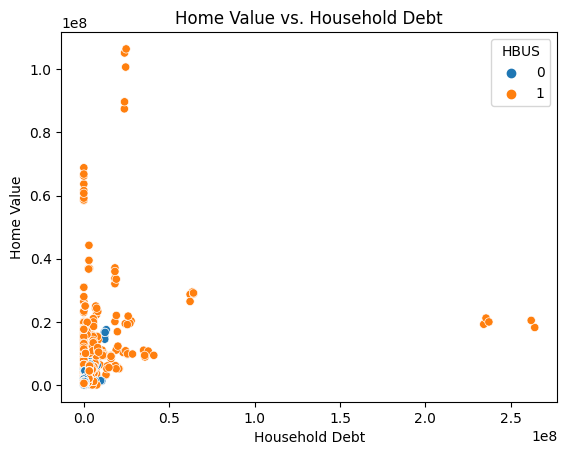

In [6]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x = 'DEBT',
    y = 'HOUSES',
    hue = 'HBUS',
    data = df
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");

as debt rises so does the home value for both business and non-business owners because most debt is in the mortage of the house.

In [7]:
# create subset of dataframe that owns businesses with income < $500K
mask = (df['HBUS']==1) & (df["INCOME"]<500_000)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


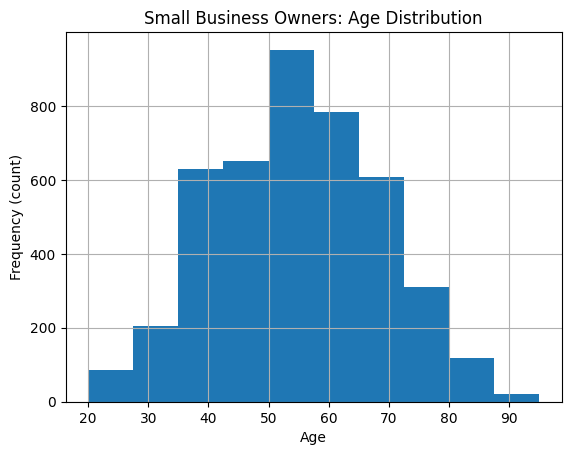

In [8]:
# Plot histogram of "AGE"
df_small_biz['AGE'].hist(bins=10)
plt.xlabel('Age')
plt.ylabel('Frequency (count)')
plt.title('Small Business Owners: Age Distribution');

Most of the small business owners are between 50 and 60 years old. But the main chunk of everyone is between 35 and 70 years old.

In [9]:
# create race replacement dictionary
race_dict = {
    1: "White/Non-Hispanic",
    2: "Black/African-American",
    3: "Hispanic",
    5: "Other",
}

# uodate race column and counts values for small business owners
race = df_small_biz['RACE'].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
race_value_counts

White/Non-Hispanic        0.828139
Hispanic                  0.069890
Other                     0.055454
Black/African-American    0.046517
Name: RACE, dtype: float64

More than 80% of respondents with small businesses are white/non-hispanic.

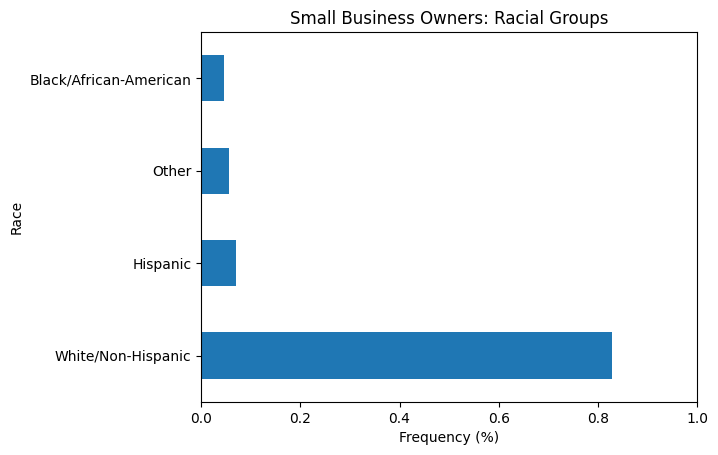

In [10]:
# Create bar chart of race_value_counts
race_value_counts.plot(kind='barh')
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("Small Business Owners: Racial Groups");

In [11]:
# calculate racial grop of all respondents
race2 = df['RACE'].replace(race_dict)
race_value_counts_2 = race2.value_counts(normalize=True)
race_value_counts_2

White/Non-Hispanic        0.716739
Black/African-American    0.130068
Hispanic                  0.096625
Other                     0.056569
Name: RACE, dtype: float64

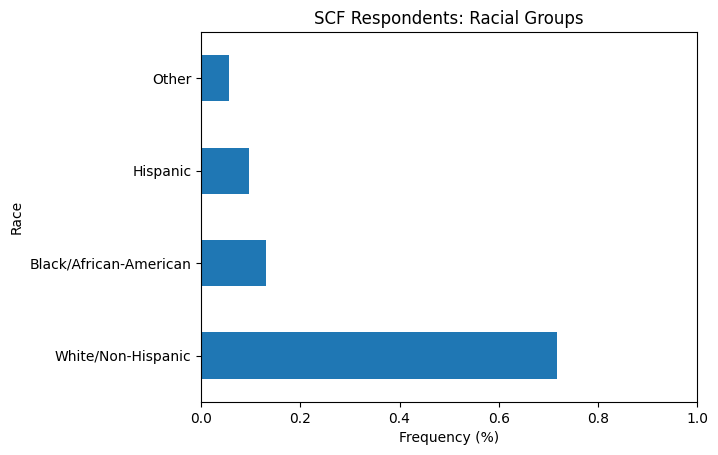

In [12]:
# Create bar chart of race_value_counts
race_value_counts_2.plot(kind='barh')
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("SCF Respondents: Racial Groups");

White/Non-Hispanics account for about 72% of the whole respondents but about 83% of small business owners. On the other hand, Black and Hispanic respondents represent 22% of all respondents but 12% of small business owners. In other words, Black and Hispanic households are actually less likely to own a business. 

In [14]:
# create educational replacement dictionary
educ_dict = {
    -1: "LESS THAN 1ST GRADE",
    1: "1ST, 2ND, 3RD, OR 4TH GRADE",
    2: "5TH OR 6TH GRADE",
    3: "7TH OR 8TH GRADE",
    4: "9TH GRADE",
    5: "10TH GRADE",
    6: "11TH GRADE",
    7: "12TH GRADE, NO DIPLOMA",
    8: "HIGH SCHOOL GRADUATE - HIGH SCHOOL DIPLOMA OR EQUIVALENT",
    9: "SOME COLLEGE BUT NO DEGREE",
    10: "ASSOCIATE DEGREE IN COLLEGE - OCCUPATION/VOCATION PROGRAM",
    11: "ASSOCIATE DEGREE IN COLLEGE - ACADEMIC PROGRAM",
    12: "BACHELOR'S DEGREE (FOR EXAMPLE: BA, AB, BS)",
    13: "MASTER'S DEGREE",
    14: "DOCTORATE OR PROFESSIONAL SCHOOL DEGREE"
}

# calculate 
df_educ = (
    df['EDUC']
    .replace(educ_dict)
    .groupby(df['HBUS'])
    .value_counts(normalize=True)
    .rename('frequency')
    .to_frame()
    .reset_index()
)
df_educ.head()

,HBUS,EDUC,frequency
0,0,HIGH SCHOOL GRADUATE - HIGH SCHOOL DIPLOMA OR ...,0.236814
1,0,"BACHELOR'S DEGREE (FOR EXAMPLE: BA, AB, BS)",0.214211
2,0,SOME COLLEGE BUT NO DEGREE,0.163138
3,0,MASTER'S DEGREE,0.109967
4,0,ASSOCIATE DEGREE IN COLLEGE - OCCUPATION/VOCAT...,0.061660


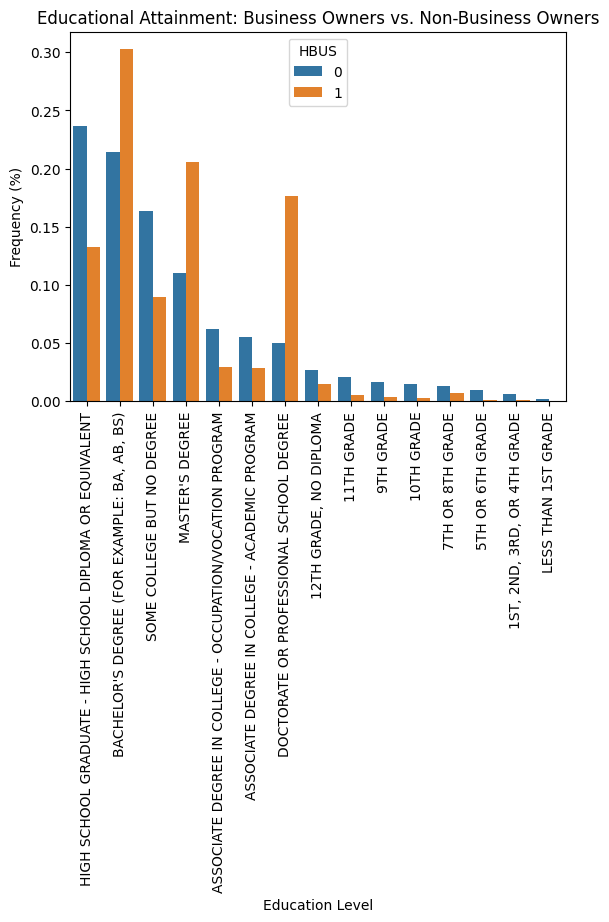

In [38]:
# Create bar chart of `df_educ`
sns.barplot(
    x = 'EDUC',
    y = 'frequency',
    data = df_educ,
    hue = 'HBUS'
)
plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=90)
plt.title("Educational Attainment: Business Owners vs. Non-Business Owners");

A business owners is more like to have achieved a graduate and post graduate than a non-bussiness owner. A large portion of non-business owners have a high school diploma.

In [16]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

In [17]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var, limits=(0.1,0.1)).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

In [18]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x = top_ten_trim_var,
    y = top_ten_trim_var.index,
    title = "Small Business Owners: High Variance Features",
    height=500, 
    width=1000
    
)
fig. update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")
fig.show()

In [19]:
# generate list of high variance columns
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

### Split

In [20]:
# define target dataframe
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)

X shape: (4364, 5)


## Build Model

### Iterate

In [23]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
#     initialize model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, n_init='auto', random_state=42))
#     train model
    model.fit(X)
#     calculate inertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
#     calculate silhoutte score
    silhouette_scores.append(silhouette_score(X, model.named_steps['kmeans'].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5772.342660776854, 3070.4294488357573, 2220.4200222846457, 1777.591394261521, 1510.4144379813906, 1177.758813689842, 1004.008232928737, 898.0757155898192, 787.7995635759676, 748.8553046198408, 691.0380523318926]

Silhouette Scores: [0.9577268088436816, 0.8446503900103915, 0.7423126115584432]


In [25]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x = n_clusters,
    y = inertia_errors,
    title = "K-Means Model: Inertia vs Number of Clusters",
    height=500, 
    width=1000
)

fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

In [26]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x = n_clusters,
    y = silhouette_scores,
    title = "K-Means Model: Silhoutte Score vs Number of Clusters",
    height=500, 
    width=1000
)

fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhoutte Score")
fig.show()

In [27]:
# train final model
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, n_init='auto' ,random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans',
                 KMeans(n_clusters=3, n_init='auto', random_state=42))])

## Communicate

In [28]:
labels = final_model.named_steps['kmeans'].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08
2,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07


In [29]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode = 'group',
    title = 'Small Business Owner Finances by Cluster',
    height=500, 
    width=1000
)

fig.update_layout(xaxis_title='Cluster', yaxis_title='Value [$]')
fig.show()

In [30]:
# Instantiate transformer
pca = PCA(n_components = 2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638839
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


In [32]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame = X_pca,
    x = "PC1",
    y = "PC2",
    color = labels.astype(str),
    title = "PCA Representation of Clusters",
    height=500, 
    width=1000
)

fig.update_layout(xaxis_title = "PC1", yaxis_title = "PC2")
fig.show()